In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error as MSE
from scipy.stats import spearmanr, pearsonr
from sklearn import metrics
from sklearn.metrics import classification_report
from scipy.cluster import hierarchy as hc
import scipy
from collections import Counter

In [2]:
df = pd.read_csv('Absenteeism_at_work.csv',sep=';')

In [3]:
temp=df.copy()

In [4]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740 entries, 0 to 739
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ID                               740 non-null    int64  
 1   Reason for absence               740 non-null    int64  
 2   Month of absence                 740 non-null    int64  
 3   Day of the week                  740 non-null    int64  
 4   Seasons                          740 non-null    int64  
 5   Transportation expense           740 non-null    int64  
 6   Distance from Residence to Work  740 non-null    int64  
 7   Service time                     740 non-null    int64  
 8   Age                              740 non-null    int64  
 9   Work load Average/day            740 non-null    float64
 10  Hit target                       740 non-null    int64  
 11  Disciplinary failure             740 non-null    int64  
 12  Education             

In [5]:
temp['Reason for absence'] = df['Reason for absence'].astype('category')
temp['Month of absence'] = df['Month of absence'].astype('category')
temp['Day of the week'] = df['Day of the week'].astype('category')
temp['Seasons'] = df['Seasons'].astype('category')
temp['Disciplinary failure'] = df['Disciplinary failure'].astype('bool')
temp['Education'] = df['Education'].astype('category')
temp['Social drinker'] = df['Social drinker'].astype('bool')
temp['Social smoker'] = df['Social smoker'].astype('bool')

In [6]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740 entries, 0 to 739
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   ID                               740 non-null    int64   
 1   Reason for absence               740 non-null    category
 2   Month of absence                 740 non-null    category
 3   Day of the week                  740 non-null    category
 4   Seasons                          740 non-null    category
 5   Transportation expense           740 non-null    int64   
 6   Distance from Residence to Work  740 non-null    int64   
 7   Service time                     740 non-null    int64   
 8   Age                              740 non-null    int64   
 9   Work load Average/day            740 non-null    float64 
 10  Hit target                       740 non-null    int64   
 11  Disciplinary failure             740 non-null    bool    
 12  Educatio

In [7]:
pd.options.display.max_columns=None
pd.options.display.max_rows=None

In [8]:
temp.head()

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
0,11,26,7,3,1,289,36,13,33,239.554,97,False,1,2,True,False,1,90,172,30,4
1,36,0,7,3,1,118,13,18,50,239.554,97,True,1,1,True,False,0,98,178,31,0
2,3,23,7,4,1,179,51,18,38,239.554,97,False,1,0,True,False,0,89,170,31,2
3,7,7,7,5,1,279,5,14,39,239.554,97,False,1,2,True,True,0,68,168,24,4
4,11,23,7,5,1,289,36,13,33,239.554,97,False,1,2,True,False,1,90,172,30,2


In [9]:
len(temp[temp['Absenteeism time in hours']==0])

44

In [10]:
len(temp[temp['Disciplinary failure']==True])

40

In [11]:
len(temp[(temp['Absenteeism time in hours']==0) & (temp['Disciplinary failure']==False)])

4

In [12]:
temp[(temp['Absenteeism time in hours']==0) & (temp['Disciplinary failure']==False)]


,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
134,34,27,1,2,2,118,10,10,37,308.593,95,False,1,0,False,False,0,83,172,28,0
737,4,0,0,3,1,118,14,13,40,271.219,95,False,1,1,True,False,8,98,170,34,0
738,8,0,0,4,2,231,35,14,39,271.219,95,False,1,2,True,False,2,100,170,35,0
739,35,0,0,6,3,179,45,14,53,271.219,95,False,1,1,False,False,1,77,175,25,0


In [13]:
print("Since column 737,738 and 739 have 0 absent entries we ignore them for the time being ")

Since column 737,738 and 739 have 0 absent entries we ignore them for the time being 


In [14]:
temp = temp[temp['Month of absence'] != 0]

In [15]:
temp[temp['Reason for absence']==27][['Absenteeism time in hours']].mean()

Absenteeism time in hours    2.275362
dtype: float64

In [16]:
print("We find that the 134th entry for ID 34 has a reason for absence (27),yet absenteeism in hours is given as 0. Since we find the mean for Reason for absence 27 to be 2.27, let us assign absenteeism in hours for the 134th entry as 2 hours ")

We find that the 134th entry for ID 34 has a reason for absence (27),yet absenteeism in hours is given as 0. Since we find the mean for Reason for absence 27 to be 2.27, let us assign absenteeism in hours for the 134th entry as 2 hours 


In [17]:
temp.loc[(temp['Reason for absence']==27) & (temp['Absenteeism time in hours']==0),'Absenteeism time in hours']=2

In [18]:
temp.head()

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
0,11,26,7,3,1,289,36,13,33,239.554,97,False,1,2,True,False,1,90,172,30,4
1,36,0,7,3,1,118,13,18,50,239.554,97,True,1,1,True,False,0,98,178,31,0
2,3,23,7,4,1,179,51,18,38,239.554,97,False,1,0,True,False,0,89,170,31,2
3,7,7,7,5,1,279,5,14,39,239.554,97,False,1,2,True,True,0,68,168,24,4
4,11,23,7,5,1,289,36,13,33,239.554,97,False,1,2,True,False,1,90,172,30,2


In [19]:
len(temp[temp['Absenteeism time in hours']==0])

40

In [20]:
len(temp[temp['Disciplinary failure']==True])

40

In [21]:
print("Classifying Seasons with respect to data provide: summer (1), autumn (2), winter (3), spring (4)")

Classifying Seasons with respect to data provide: summer (1), autumn (2), winter (3), spring (4)


In [22]:
s_map = {1:'Summer', 2:'Autumn', 3:'Winter', 4:'Spring'}


In [23]:
temp['Season Name'] = temp.Seasons.map(s_map)
temp['Season Name'] = temp['Season Name'].astype('category')


In [24]:
temp.head()

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours,Season Name
0,11,26,7,3,1,289,36,13,33,239.554,97,False,1,2,True,False,1,90,172,30,4,Summer
1,36,0,7,3,1,118,13,18,50,239.554,97,True,1,1,True,False,0,98,178,31,0,Summer
2,3,23,7,4,1,179,51,18,38,239.554,97,False,1,0,True,False,0,89,170,31,2,Summer
3,7,7,7,5,1,279,5,14,39,239.554,97,False,1,2,True,True,0,68,168,24,4,Summer
4,11,23,7,5,1,289,36,13,33,239.554,97,False,1,2,True,False,1,90,172,30,2,Summer


In [25]:
print("Classifying Day Of the week with respect to data provide: Monday (2), Tuesday (3), Wednesday (4), Thursday (5), Friday (6)")

Classifying Day Of the week with respect to data provide: Monday (2), Tuesday (3), Wednesday (4), Thursday (5), Friday (6)


In [26]:
day_map = {2:'Monday' , 3:'Tuesday', 4:'Wednesday', 5:'Thursday' , 6:'Friday'}

In [27]:
temp['Day_of_the_week'] = temp['Day of the week'].map(day_map)
temp['Day_of_the_week'] = temp['Day_of_the_week'].astype('category')

In [28]:
print("Classifying Reasons Of absence")

Classifying Reasons Of absence


In [29]:
reason_map = {
    0: 'No data',
    1: 'Certain infectious and parasitic diseases',
    2: 'Neoplasms',
    3: 'Diseases of the blood and blood-forming organs and certain disorders involving the immune mechanism',
    4: 'Endocrine, nutritional and metabolic diseases',
    5: 'Mental and behavioural disorders',
    6: 'Diseases of the nervous system',
    7: 'Diseases of the eye and adnexa',
    8: 'Diseases of the ear and mastoid process',
    9: 'Diseases of the circulatory system',
    10: 'Diseases of the respiratory system',
    11: 'Diseases of the digestive system',
    12: 'Diseases of the skin and subcutaneous tissue',
    13: 'Diseases of the musculoskeletal system and connective tissue',
    14: 'Diseases of the genitourinary system',
    15: 'Pregnancy, childbirth and the puerperium',
    16: 'Certain conditions originating in the perinatal period',
    17: 'Congenital malformations, deformations and chromosomal abnormalities',
    18: 'Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified',
    19: 'Injury, poisoning and certain other consequences of external causes',
    20: 'External causes of morbidity and mortality',
    21: 'Factors influencing health status and contact with health services',
    22: 'Patient follow-up',
    23: 'Medical consultation',
    24: 'Blood donation',
    25: 'Laboratory examination',
    26: 'Unjustified absence',
    27: 'Physiotherapy',
    28: 'Dental consultation'}

In [30]:
temp['Reason'] = temp['Reason for absence'].map(reason_map)

In [31]:
temp.head(5)

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours,Season Name,Day_of_the_week,Reason
0,11,26,7,3,1,289,36,13,33,239.554,97,False,1,2,True,False,1,90,172,30,4,Summer,Tuesday,Unjustified absence
1,36,0,7,3,1,118,13,18,50,239.554,97,True,1,1,True,False,0,98,178,31,0,Summer,Tuesday,No data
2,3,23,7,4,1,179,51,18,38,239.554,97,False,1,0,True,False,0,89,170,31,2,Summer,Wednesday,Medical consultation
3,7,7,7,5,1,279,5,14,39,239.554,97,False,1,2,True,True,0,68,168,24,4,Summer,Thursday,Diseases of the eye and adnexa
4,11,23,7,5,1,289,36,13,33,239.554,97,False,1,2,True,False,1,90,172,30,2,Summer,Thursday,Medical consultation


In [32]:
print('Classifying education according to: high school (1), graduate (2), postgraduate (3), master and doctor (4)')

Classifying education according to: high school (1), graduate (2), postgraduate (3), master and doctor (4)


In [33]:
edu_map = {
    1: 'High School',
    2: 'Graduate',
    3: 'Post Graduate',
    4: 'Master & Doctor'
}

In [34]:
temp['Qualification'] = temp['Education'].map(edu_map)
temp['Qualification'] = temp['Qualification'].astype('category')
df['Qualification'] = df['Education'].map(edu_map)
df['Qualification'] = df['Qualification'].astype('category')

In [35]:
month_map = {
    1: 'High School',
    2: 'Graduate',
    3: 'Post Graduate',
    4: 'Master & Doctor'
}

In [36]:
temp.head()

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours,Season Name,Day_of_the_week,Reason,Qualification
0,11,26,7,3,1,289,36,13,33,239.554,97,False,1,2,True,False,1,90,172,30,4,Summer,Tuesday,Unjustified absence,High School
1,36,0,7,3,1,118,13,18,50,239.554,97,True,1,1,True,False,0,98,178,31,0,Summer,Tuesday,No data,High School
2,3,23,7,4,1,179,51,18,38,239.554,97,False,1,0,True,False,0,89,170,31,2,Summer,Wednesday,Medical consultation,High School
3,7,7,7,5,1,279,5,14,39,239.554,97,False,1,2,True,True,0,68,168,24,4,Summer,Thursday,Diseases of the eye and adnexa,High School
4,11,23,7,5,1,289,36,13,33,239.554,97,False,1,2,True,False,1,90,172,30,2,Summer,Thursday,Medical consultation,High School


# Finding the mean Absenteeism time in hours of all employees

In [37]:
temp['Absenteeism time in hours'].mean()

6.955223880597015

In [38]:
print("We find that the Average hours of being absent is around 7")

We find that the Average hours of being absent is around 7


# DATA ANALYSIS

# Distribution Of Employees according to their qualification

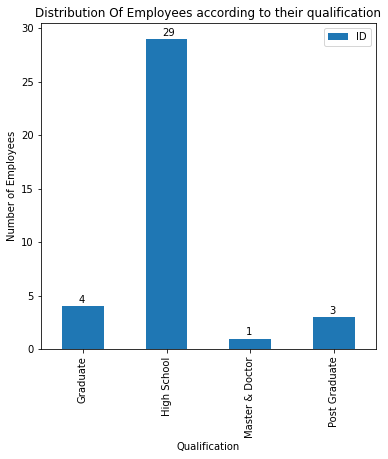

In [39]:
qualification_count = df.groupby(['Qualification']).agg({'ID': pd.Series.nunique})
ax =qualification_count.plot(kind='bar', figsize=(6,6), legend=True)
for i, j in enumerate(qualification_count.values):
    ax.text(i-0.05, j +0.3 , str(j[0])) 
ax.set_xlabel('Qualification')
ax.set_ylabel('Number of Employees')
ax.set_title('Distribution Of Employees according to their qualification')
plt.show()

In [40]:
print('We see maximum number of employees have High School as their highest qualification')

We see maximum number of employees have High School as their highest qualification


# Distribution Of Employees according to their Age

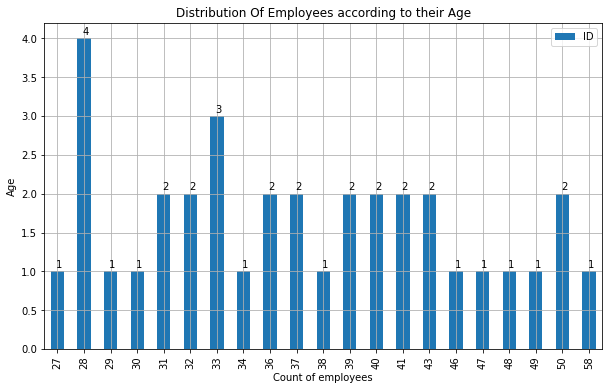

In [41]:
count1 = temp.groupby(['Age']).agg({'ID': pd.Series.nunique})
ax = count1.plot(kind='bar', figsize=(10,6), legend=True)
for i, j in enumerate(count1.values):
    ax.text(i-0.05, j +0.05, str(j[0]))
ax.set_xlabel('Count of employees')
ax.set_ylabel('Age')
ax.set_title('Distribution Of Employees according to their Age')
plt.grid()
plt.show()

# Showing how Absenteeism time in hours is varying with Age

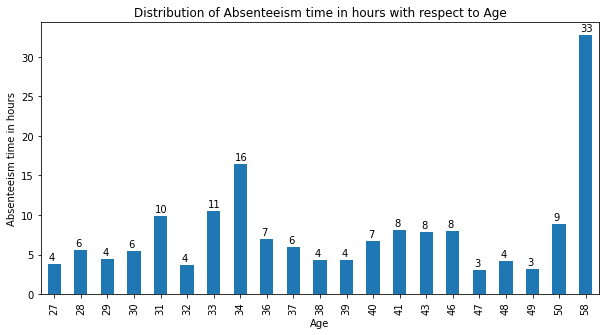

In [42]:
age_count = temp.groupby('Age')[['Absenteeism time in hours']].mean()
ax = age_count.plot(kind='bar', figsize=(10,5), legend=False)
for i, j in enumerate(age_count.values):
    ax.text(i-.2, j+0.5 , str(int(np.round(j))))
ax.set_ylabel('Absenteeism time in hours')
ax.set_title('Distribution of Absenteeism time in hours with respect to Age')
plt.show()

# This graph shows, that hours of absence have some correlation with age of employee ,i.e More the Age,more is the tendency to take leaves.

# Another graph showing,how age plays a factor in hours of absence

Text(0.5, 1.0, 'Distribution Of Employees according to their Age')

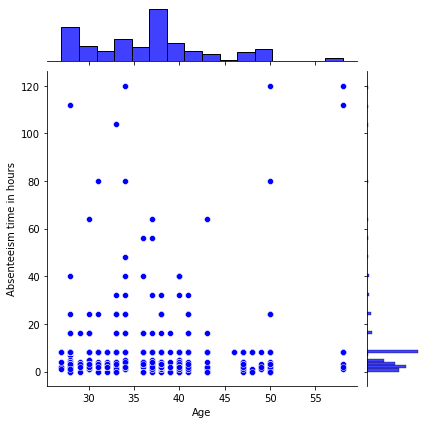

In [43]:
sns.jointplot(x='Age',y='Absenteeism time in hours',data=temp,kind='scatter',color='blue')
ax.set_xlabel('Age')
ax.set_ylabel('Absenteeism time in hours')
ax.set_title('Distribution Of Employees according to their Age')

# Ilustrating how Absenteeism is affected by presence of children

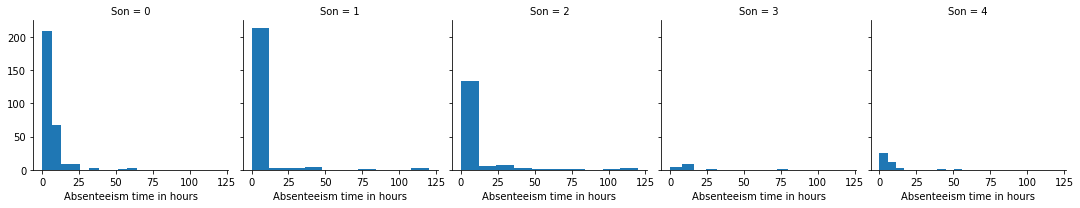

In [44]:
ax = sns.FacetGrid(data=temp,col='Son')
ax.map(plt.hist,'Absenteeism time in hours')

In [45]:
print('Here all possible options for "Son"(i.e 0,1,2,3,4) column are shown in their correlation with absence time. We can see that employees with none, 1 or 2 children, are more likely to be absent at work.')

Here all possible options for "Son"(i.e 0,1,2,3,4) column are shown in their correlation with absence time. We can see that employees with none, 1 or 2 children, are more likely to be absent at work.


# Ilustrating If Absenteeism is affected by presence of pets

<ipython-input-46-4684c53fcf48>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  pet_count = temp.groupby('ID')['Pet','Absenteeism time in hours'].sum()


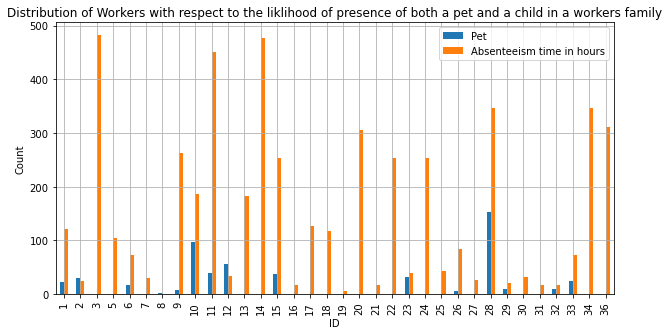

In [46]:
pet_count = temp.groupby('ID')['Pet','Absenteeism time in hours'].sum()
ax = pet_count.plot(kind='bar', figsize=(10,5), legend=True)
ax.set_ylabel('Count')
ax.set_title('Distribution of Workers with respect to the liklihood of presence of both a pet and a child in a workers family')
plt.grid()
plt.show()

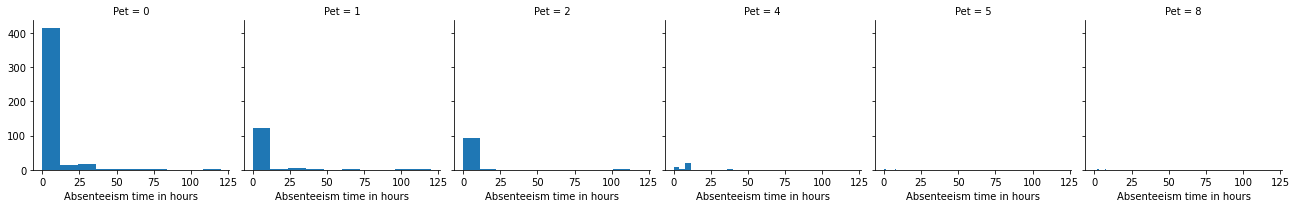

In [47]:
ax = sns.FacetGrid(data=temp,col='Pet')
ax.map(plt.hist,'Absenteeism time in hours')

# We see that presence of a Pet is not likely to affect the Absenteeism of employees

# Ilustrating the liklihood of presence of both a pet and a child in an employees family

<ipython-input-48-49eb12427ebe>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  son_pet_count = temp.groupby('ID')['Pet','Son'].mean()


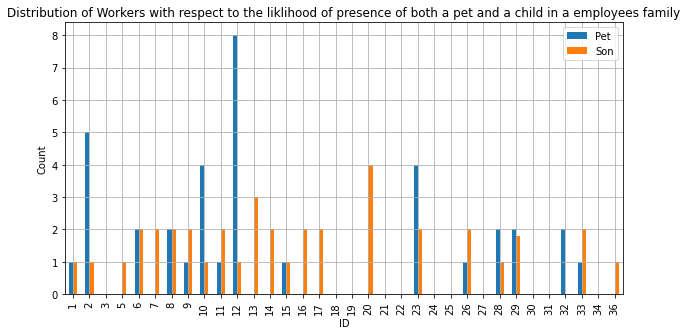

In [48]:
son_pet_count = temp.groupby('ID')['Pet','Son'].mean()
ax = son_pet_count.plot(kind='bar', figsize=(10,5), legend=True)
ax.set_ylabel('Count')
ax.set_title('Distribution of Workers with respect to the liklihood of presence of both a pet and a child in a employees family')
plt.grid()
plt.show()

# Thus we can see that employees having a child are most likely to have a pet as well and viceversa

# Analysis Of Relationship between Absenteeism and Seasons :


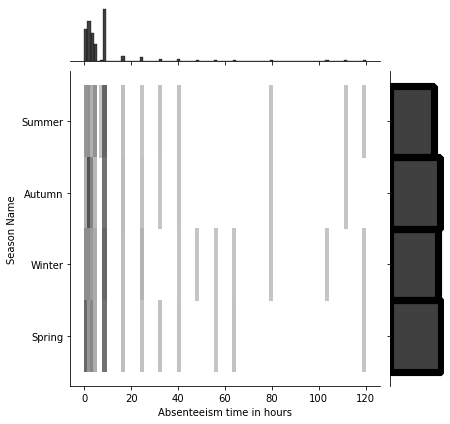

In [49]:
sns.jointplot(x='Absenteeism time in hours',y='Season Name',data=temp,kind='hist',color='black')

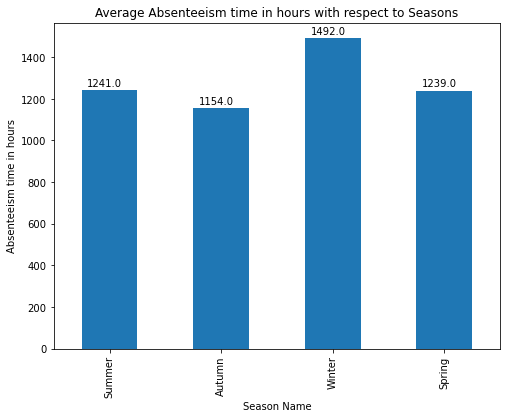

In [50]:
season_count = temp.groupby('Season Name')[['Absenteeism time in hours']].sum()
ax = season_count.plot(kind='bar', figsize=(8,6), legend=False)
for i, j in enumerate(season_count.values):
    ax.text(i-.2, j+20 , str(j[0].mean()))
ax.set_ylabel('Absenteeism time in hours')
ax.set_title('Average Absenteeism time in hours with respect to Seasons')
plt.show()

# We can see that maximum absenteeism at work is seen in Winter season

# Analysing Relationship between Absenteeism and Day of the week :

C:\Users\soura\anaconda3\lib\site-packages\seaborn\regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 864x432 with 0 Axes>

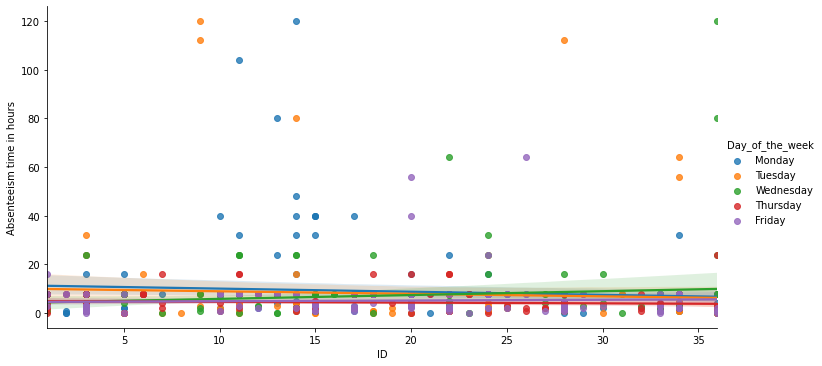

In [51]:
plt.figure(figsize=(12,6))
sns.lmplot(x='ID',y='Absenteeism time in hours',data=temp,hue='Day_of_the_week',size=5,aspect=2)

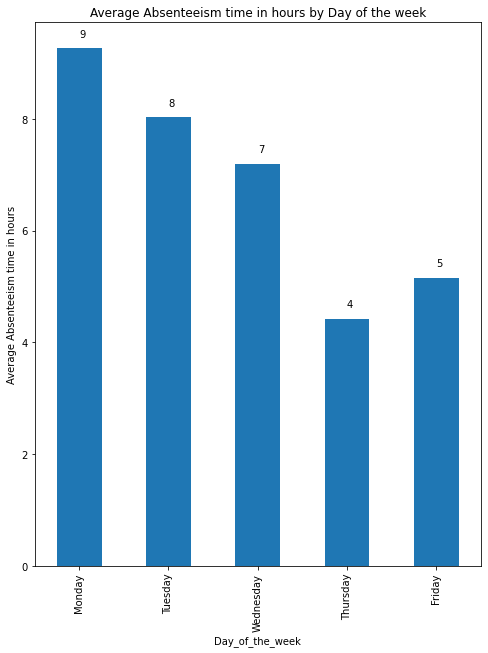

In [52]:
day_count = temp.groupby('Day_of_the_week')[['Absenteeism time in hours']].mean()
ax = day_count.plot(kind='bar', figsize=(8,10), legend=False)
for i, j in enumerate(day_count.values):
    ax.text(i, j+0.2, str(int(np.round(j))))
ax.set_ylabel('Average Absenteeism time in hours')
ax.set_title('Average Absenteeism time in hours by Day of the week')
plt.show()

# #Thus we can see that maximum leaves are taken on Mondays

# illustrating total Absenteeism time in hours with respect to reasons used:

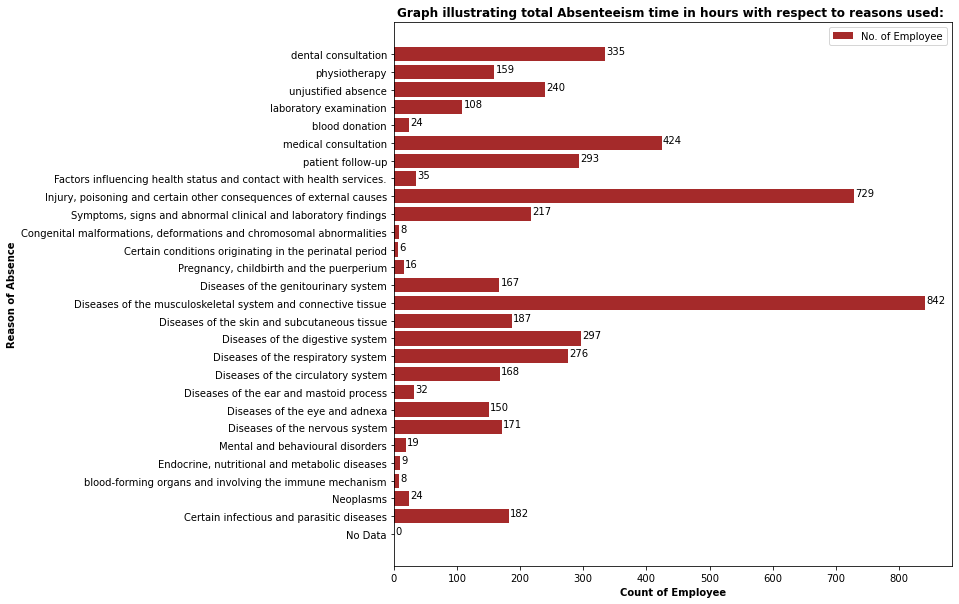

In [53]:
reason_count= temp.groupby('Reason for absence')
reason_count['Absenteeism time in hours'].sum()
arr=reason_count['Absenteeism time in hours'].sum()
arr=np.array(arr)
fig, ax = plt.subplots(figsize=(10,10))
table=[
'No Data','Certain infectious and parasitic diseases', 
'Neoplasms', 
'blood-forming organs and involving the immune mechanism', 
'Endocrine, nutritional and metabolic diseases', 
'Mental and behavioural disorders', 
'Diseases of the nervous system', 
'Diseases of the eye and adnexa', 
'Diseases of the ear and mastoid process', 
'Diseases of the circulatory system', 
'Diseases of the respiratory system', 
'Diseases of the digestive system', 
'Diseases of the skin and subcutaneous tissue', 
'Diseases of the musculoskeletal system and connective tissue', 
'Diseases of the genitourinary system',
'Pregnancy, childbirth and the puerperium',
'Certain conditions originating in the perinatal period',
'Congenital malformations, deformations and chromosomal abnormalities', 
'Symptoms, signs and abnormal clinical and laboratory findings', 
'Injury, poisoning and certain other consequences of external causes', 
'Factors influencing health status and contact with health services.',
'patient follow-up',
'medical consultation',
'blood donation',
'laboratory examination',
'unjustified absence',
'physiotherapy',
'dental consultation']
plt.barh(y=np.arange(len(arr)),width=arr,label='No. of Employee',color='brown')
plt.yticks(np.arange(len(arr)),table)
plt.ylabel('Reason of Absence',fontweight='bold')
plt.xlabel('Count of Employee',fontweight='bold')
plt.title('Graph illustrating total Absenteeism time in hours with respect to reasons used: ',fontweight='bold',color='black')
plt.legend()
for i, v in enumerate(arr):
    ax.text(v+2, i, str(v), color='black')
plt.show()

In [54]:
reason = temp.groupby('Reason', as_index=False)['Absenteeism time in hours'].sum()
with pd.option_context('display.max_colwidth', -1):
    display(reason.sort_values('Absenteeism time in hours', ascending=False).style.hide_index())

Reason,Absenteeism time in hours
Diseases of the musculoskeletal system and connective tissue,842
"Injury, poisoning and certain other consequences of external causes",729
Medical consultation,424
Dental consultation,335
Diseases of the digestive system,297
Patient follow-up,293
Diseases of the respiratory system,276
Unjustified absence,240
"Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified",217
Diseases of the skin and subcutaneous tissue,187


# Showing how smoking and drinking plays a role in Absenteeism 

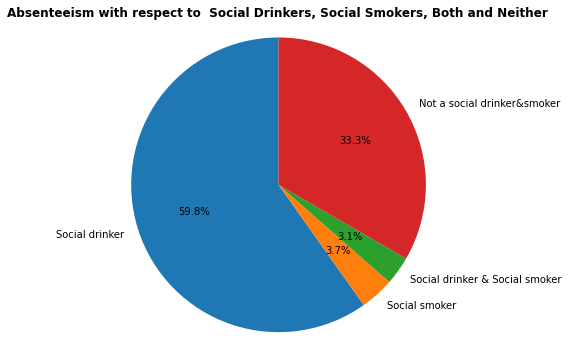

In [55]:
drink_sum = temp[(temp['Social drinker'] == True) & (temp['Social smoker']==False)]['Absenteeism time in hours'].sum()
smok_sum = temp[(temp['Social drinker'] == False) & (temp['Social smoker']==True)]['Absenteeism time in hours'].sum()
drink_smok_sum = temp[(temp['Social drinker'] == True) & (temp['Social smoker']==True)]['Absenteeism time in hours'].sum()
abs_sum = temp[(temp['Social drinker'] == False) & (temp['Social smoker']==False)]['Absenteeism time in hours'].sum()
absen = [drink_sum, smok_sum, drink_smok_sum, abs_sum]
explode = (0, 0, 0, 0)
labels = 'Social drinker', 'Social smoker', 'Social drinker & Social smoker', 'Not a social drinker&smoker'
fig1, ax1 = plt.subplots(figsize=(8, 6))
ax1.pie(absen, explode=explode, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.set_title('Absenteeism with respect to  Social Drinkers, Social Smokers, Both and Neither',fontweight='bold')
ax1.axis('equal')  

plt.show()


# Thus we can see that Total absenteeism constitutes of 59.8% of social drinkers indicating that it plays a role in the absenteeism nature among employees

# Showing which month has the highest Absenteeism time: 

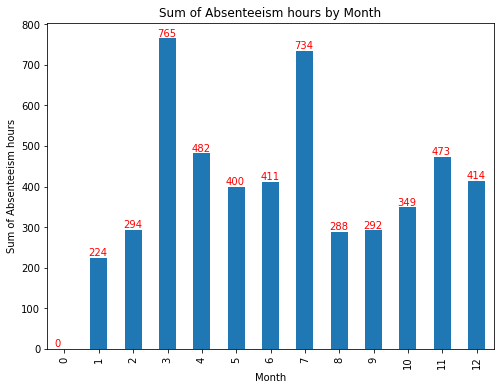

In [56]:
month = temp.groupby('Month of absence')['Absenteeism time in hours'].sum()
ax = month.plot(kind='bar', figsize=(8,6), legend=False)
for i, v in enumerate(month.values):
    ax.text(i-0.3, v + 5, str(np.int(np.round(v))), color='red')
ax.set_xlabel('Month')
ax.set_ylabel('Sum of Absenteeism hours')
ax.set_title('Sum of Absenteeism hours by Month')
plt.show()

# We see that the month of March(3) has the highest number of Absents

# Thus we can see that there are a number of factors that plays a key role in the absenteeism nature among the employees and certain regulations can help reduce this tendency.